<a href="https://colab.research.google.com/github/aapolaivm/Google-Colab-algorithms/blob/main/Eye_tracker_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def load_data(files):
    # Load data from a list of CSV file.
    data_frames = {}
    for file in files:
            df = pd.read_csv(file)
            data_frames[file] = df
    return data_frames

def clean_and_preprocess(data_frames):
    final_dfs = {}
    for name, df in data_frames.items():
        df.columns = df.columns.str.replace(' ', '')

        # Filtering invalid data points
        df = df[df['validity'] == 1].copy()
        # Converting timestamps from microseconds to seconds
        df['timestamp(s)'] = df['timestamp(us)'] / 1e6

        if not(df.empty):
            total_duration = df['timestamp(s)'].iloc[-1] - df['timestamp(s)'].iloc[0]
            excess_duration = total_duration - 50.1

            # Calculate the start and end timestamps for the 50-second window
            start_timestamp = df['timestamp(s)'].iloc[0] + (excess_duration / 2)
            end_timestamp = df['timestamp(s)'].iloc[-1] - (excess_duration / 2)

            # Finding the closest timestamps in the data to the start and end timestamps
            closest_start = df.iloc[(df['timestamp(s)'] - start_timestamp).abs().argsort()[:1]].iloc[0]['timestamp(s)']
            closest_end = df.iloc[(df['timestamp(s)'] - end_timestamp).abs().argsort()[:1]].iloc[0]['timestamp(s)']

            # Trimming the dataframe to the exact 50 seconds window
            trimmed_df = df[(df['timestamp(s)'] > closest_start) & (df['timestamp(s)'] < closest_end)]

            final_dfs[name] = trimmed_df
    return final_dfs


files = ['participant_1.csv', 'participant_2.csv', 'participant_3.csv', 'participant_4.csv']
data_frames = load_data(files)
final_dfs = clean_and_preprocess(data_frames)


In [3]:
# spilitting the data of each participant for each stimulua
def split_by_stimulus(data_frames):
    segmented_data = {}
    for name, df in data_frames.items():
        segments = {}
        start_time = df['timestamp(s)'].iloc[0]
        for i in range(5):
            # Calculate start and end times for each stimulus
            segment_start = start_time + (i * 10)
            segment_end = segment_start + 10

            # splitting the DataFrame
            segment_df = df[(df['timestamp(s)'] >= segment_start) & (df['timestamp(s)'] < segment_end)]
            segments[f'stimulus_{i+1}'] = segment_df

        segmented_data[name] = segments
    return segmented_data


segmented_dfs = split_by_stimulus(final_dfs)

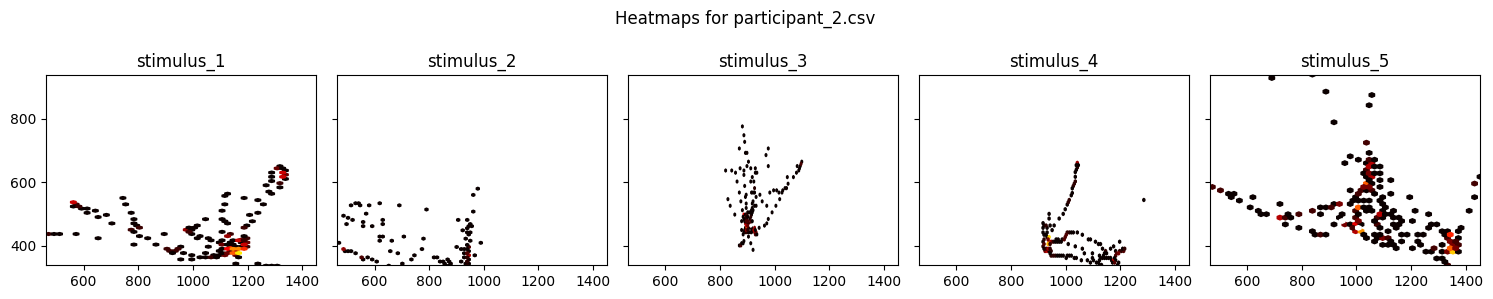

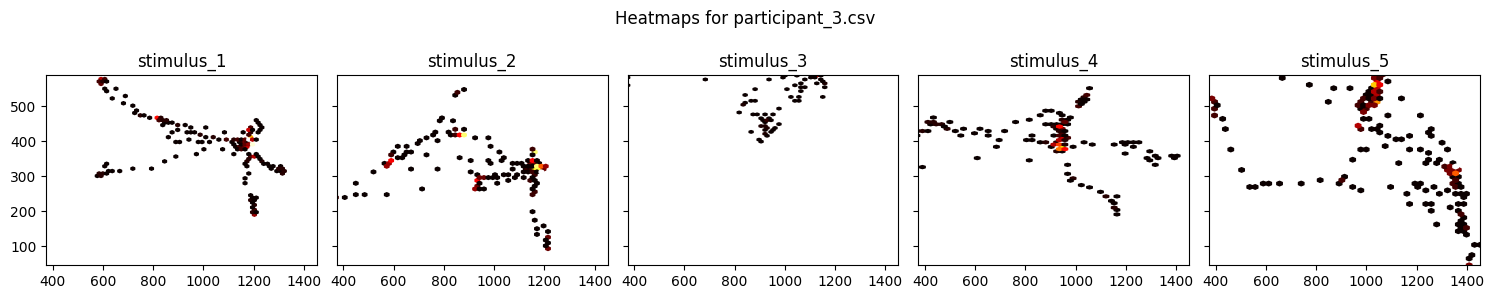

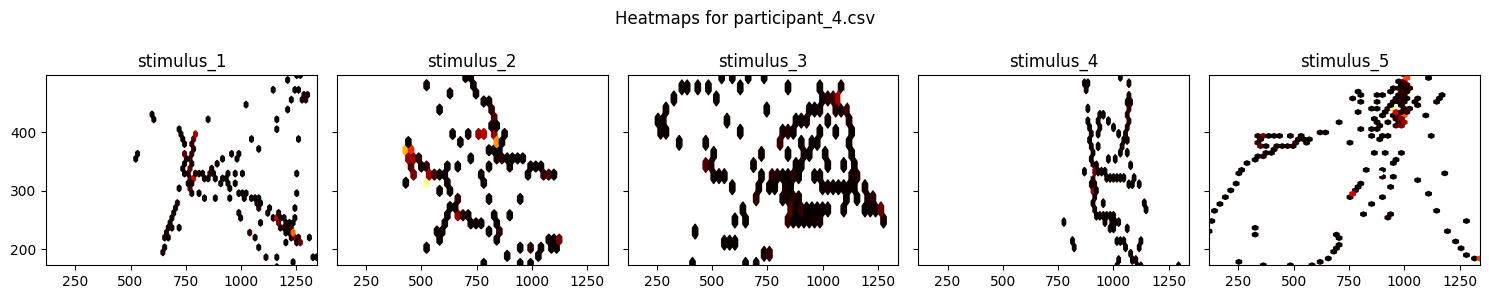

In [4]:
# cerating heat map of the locations reported by eye tracker for each participant
def plot_heatmaps(segmented_data):
    for name, segments in segmented_data.items():
        fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)

        fig.suptitle(f'Heatmaps for {name}')

        for i, (segment_name, df) in enumerate(segments.items()):
            if not df.empty:
                axes[i].hexbin(df['x'], df['y'], gridsize=50, cmap='hot', mincnt=1)
                axes[i].set_title(segment_name)
                axes[i].set_xlim(df['x'].min(), df['x'].max())
                axes[i].set_ylim(df['y'].min(), df['y'].max())

        plt.tight_layout()
        plt.show()

plot_heatmaps(segmented_dfs)

In [5]:
# Detect fixation for each participant
def detect_fixations(df_et, max_dispersion, min_duration):
    gaze_data = list(zip(df_et['x'], df_et['y']))
    events = []
    fixation_start = 0

    for i in range(len(gaze_data)):
        # Calculate dispersion
        dispersion = calculate_dispersion(gaze_data[fixation_start:i+1])

        # Check if dispersion exceeds threshold or it's the last point
        if dispersion > max_dispersion or i == len(gaze_data) - 1:
            duration = i - fixation_start + 1  # Include the current point
            if duration >= min_duration:
                # Extend fixation for the duration
                events.extend(['Fixation'] * duration)
            else:
                # Extend saccade for the duration
                events.extend(['Saccade'] * duration)

            # Reset fixation start
            fixation_start = i + 1

    return events

# Function to calculate dispersion of gaze points
def calculate_dispersion(gaze_points):
    gaze_points = [(float(x), float(y)) for x, y in gaze_points]
    # Compute the maximum and minimum x and y coordinates
    max_x = max(point[0] for point in gaze_points)
    min_x = min(point[0] for point in gaze_points)
    max_y = max(point[1] for point in gaze_points)
    min_y = min(point[1] for point in gaze_points)

    # Calculate dispersion as the greatest distance between any two points
    dispersion = max(max_x - min_x, max_y - min_y)
    return dispersion

In [6]:
# Defining parameter sets for each set of DataFrames
param_set_1_2 = (70, 10)  # max_dispersion and min_duration
param_set_1_3 = (50, 5)
param_set_1_4 = (130, 20)

param_set_2_2 = (90, 10)  # max_dispersion and min_duration
param_set_2_3 = (70, 5)
param_set_2_4 = (150, 20)

param_sets_1 = [param_set_1_2, param_set_1_3, param_set_1_4]
param_sets_2 = [param_set_2_2, param_set_2_3, param_set_2_4]

# Iterating through first set of DataFrames in segmented_dfs
for i, (set_key, set_value) in enumerate(segmented_dfs.items()):
    current_params = param_sets_1[i]
    for segment_name, segment_df in set_value.items():
        events = detect_fixations(segment_df, *current_params)
        temp_df = segmented_dfs[set_key][segment_name].copy()
        temp_df.loc[:, f'Detected_Event_param1'] = events
        segmented_dfs[set_key][segment_name] = temp_df

# Iterating through second set of DataFrames in segmented_dfs
for i, (set_key, set_value) in enumerate(segmented_dfs.items()):
    current_params = param_sets_2[i]
    for segment_name, segment_df in set_value.items():
        events = detect_fixations(segment_df, *current_params)
        temp_df = segmented_dfs[set_key][segment_name].copy()
        temp_df.loc[:, f'Detected_Event_param2'] = events
        segmented_dfs[set_key][segment_name] = temp_df

In [7]:
# Initialize a new dictionary to store the concatenated DataFrames for fixation duration
concatenated_dfs = {}

# Iterate over each DataFrame in segmented_dfs
for name, segments in segmented_dfs.items():
    # Concatenate the 5 segment sub-DataFrames
    concatenated_df = pd.concat(segments.values(), ignore_index=True)
    concatenated_dfs[name] = concatenated_df

In [8]:
def calculate_fixation_stats(df):
    # Calculate fixation duration, centroid, and mean fixation duration
    # with standard deviation.
    #'Detected Event' column indicates fixations

    fixation_durations = []
    fixation_centroids = []

    current_fixation_points = []
    start_time = None

    for index, row in df.iterrows():
        if row['Detected_Event_param1'] == 'Fixation':
            if start_time is None:
                start_time = row['timestamp(s)']

            current_fixation_points.append((row['x'], row['y']))
        else:
            if start_time is not None:
                # Calculate duration
                duration = row['timestamp(s)'] - start_time
                fixation_durations.append(duration)

                # Calculate centroid
                centroid_x = sum(x for x, _ in current_fixation_points) / len(current_fixation_points)
                centroid_y = sum(y for _, y in current_fixation_points) / len(current_fixation_points)
                fixation_centroids.append((centroid_x, centroid_y))

                # Reset for next fixation
                current_fixation_points = []
                start_time = None

    # Compute mean and standard deviation for durations
    mean_duration = np.mean(fixation_durations) if fixation_durations else 0
    std_duration = np.std(fixation_durations) if fixation_durations else 0

    return mean_duration, std_duration, fixation_centroids

# Calculate and aggregate stats for each CSV file
all_mean_durations = []
all_durations_std = []

for name, df in concatenated_dfs.items():
    mean_duration, std_duration, centroids = calculate_fixation_stats(df)
    all_mean_durations.append(mean_duration)
    all_durations_std.append(std_duration)
    print(f"For {name}: Mean Duration = {mean_duration}, Standard Deviation = {std_duration}, Centroids = {centroids}")

# Aggregated stats across all subjects
aggregated_mean_duration = np.mean(all_mean_durations)
aggregated_std_duration = np.mean(all_durations_std)
print(f"Aggregated Mean Duration: {aggregated_mean_duration}, Aggregated Standard Deviation: {aggregated_std_duration}")


For participant_2.csv: Mean Duration = 0.8336230937420623, Standard Deviation = 0.7281659662222686, Centroids = [(1312.595, 605.29025), (997.1699000000002, 443.69410000000005), (1165.6608247422682, 400.7917938144329), (1323.4799999999998, 630.8997142857144), (1142.103125, 382.17924999999997), (582.5104285714285, 526.0280714285715), (918.2525882352941, 280.93123529411764), (951.3699705882352, 254.00697058823533), (941.590625, 298.80025000000006), (913.2258235294116, 308.21947058823525), (477.09027272727275, 404.83072727272724), (920.8415333333334, 278.79299999999995), (931.9922631578947, 305.62342105263156), (901.1103333333334, 508.2352), (915.1577297297298, 477.8608378378378), (899.1583076923076, 472.9570512820511), (911.8212407407407, 457.1112037037037), (1202.6438095238095, 320.64966666666663), (960.6824259259258, 421.8095000000001), (1166.2833333333335, 361.309375), (942.9934492753622, 396.22075362318844), (938.6157826086957, 401.5879130434783), (1032.1118181818183, 600.890636363636

In [9]:
def calculate_fixations_for_sets(df, param_set):

    fixations = 0
    fixation_durations = []
    start_time = None

    for index, row in df.iterrows():
        if row[f'Detected_Event_param{param_set}'] == 'Fixation':
            fixations +=1
            if start_time is None:
                start_time = row['timestamp(s)']
        else:
            if start_time is not None:
                # Calculate duration
                duration = row['timestamp(s)'] - start_time
                fixation_durations.append(duration)

                start_time = None

    # Compute mean and standard deviation for durations
    mean_duration = np.mean(fixation_durations) if fixation_durations else 0

    return mean_duration, fixations

all_mean_durations_for_sets = []
all_fixations_for_sets = []

for name, df in concatenated_dfs.items():
    mean_duration, fixations = calculate_fixations_for_sets(df,1)
    all_mean_durations_for_sets.append(mean_duration)
    all_fixations_for_sets.append(fixations)
    print(f"For {name} and parameter set 1: Mean Duration = {mean_duration} Fixations = {fixations}")

for name, df in concatenated_dfs.items():
    mean_duration, fixations = calculate_fixations_for_sets(df,2)
    all_mean_durations_for_sets.append(mean_duration)
    all_fixations_for_sets.append(fixations)
    print(f"For {name} and parameter set 2: Mean Duration = {mean_duration} Fixations = {fixations}")

For participant_2.csv and parameter set 1: Mean Duration = 0.8336230937420623 Fixations = 826
For participant_3.csv and parameter set 1: Mean Duration = 0.9592513513650645 Fixations = 1035
For participant_4.csv and parameter set 1: Mean Duration = 1.4933885000209557 Fixations = 783
For participant_2.csv and parameter set 2: Mean Duration = 1.1021305161242885 Fixations = 1035
For participant_3.csv and parameter set 2: Mean Duration = 1.1478088611361779 Fixations = 1131
For participant_4.csv and parameter set 2: Mean Duration = 1.6231569999984155 Fixations = 798


In [10]:
# csv file for MFD and MFD SD for participants and each stimula

# Initialize DataFrame with specified columns
columns = ['subject_id', 'MFD_stimulus_1', 'MFD_stimulus_2', 'MFD_stimulus_3', 'MFD_stimulus_4', 'MFD_stimulus_5',
           'MFD_SD_stimulus_1', 'MFD_SD_stimulus_2', 'MFD_SD_stimulus_3', 'MFD_SD_stimulus_4', 'MFD_SD_stimulus_5',
           'MFD_overall', 'MFD_overall_SD']
result_df = pd.DataFrame(columns=columns)

# Process each participant and stimulus
for main_df_name, segments in segmented_dfs.items():
    participant_id = main_df_name  # Assuming the main_df_name is in the format 'ParticipantID_StimulusID'
    mean_durations = []
    durations_std = []

    for segment_name, segment_df in segments.items():
        stimulus_number = int(segment_name.split('_')[1]) - 1  # Assuming segment_name is 'Segment_X'
        mean_duration, std_duration, _ = calculate_fixation_stats(segment_df)

        # Store the results
        mean_durations.append(mean_duration)
        durations_std.append(std_duration)

    # Calculate overall MFD and MFD_SD
    overall_mean_duration = np.mean(mean_durations)
    overall_std_duration = np.mean(durations_std)

    # Populate the row for this participant
    row_data = [participant_id] + mean_durations + durations_std + [overall_mean_duration, overall_std_duration]
    result_df.loc[len(result_df)] = row_data

# Save the DataFrame to a CSV file
csv_file_path = 'eye_tracking_results.csv'
result_df.to_csv(csv_file_path, index=False)


0.8336230937420623 [826, 1035, 783, 1035, 1131, 798]


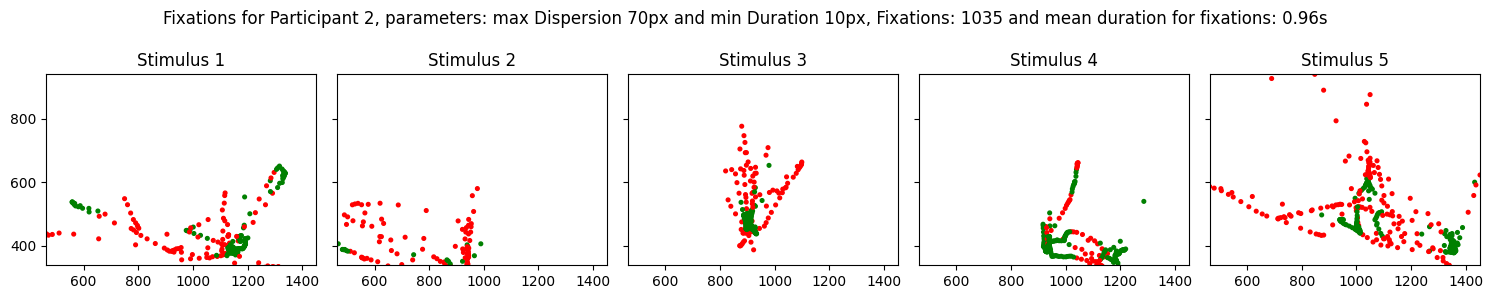

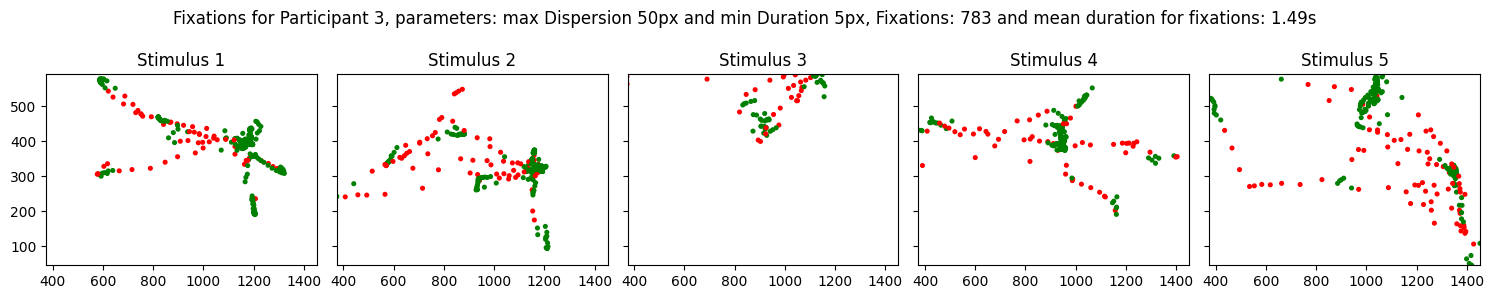

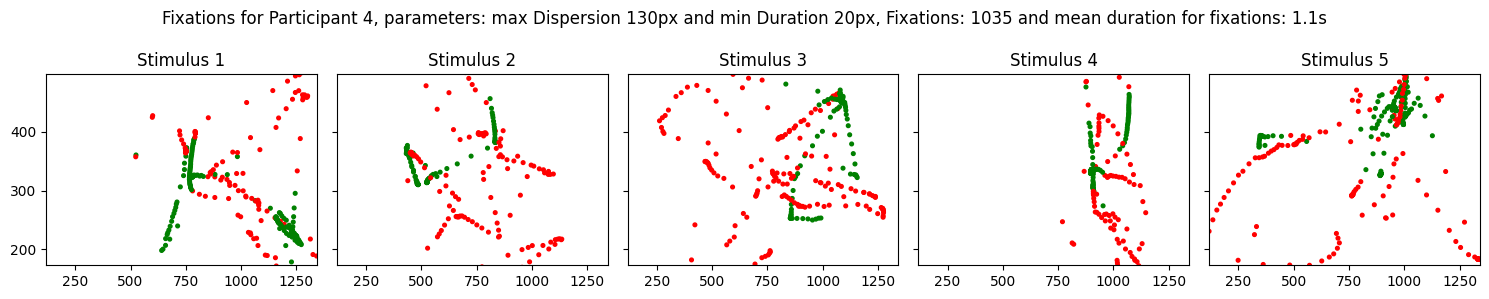

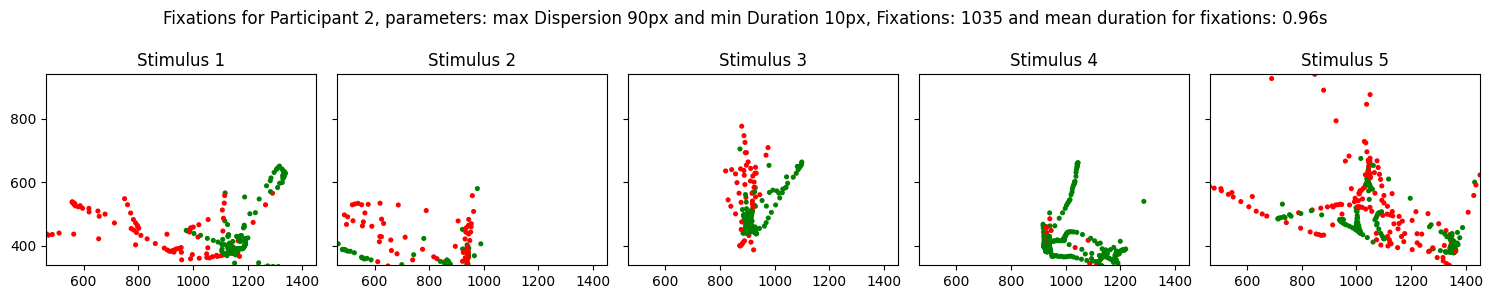

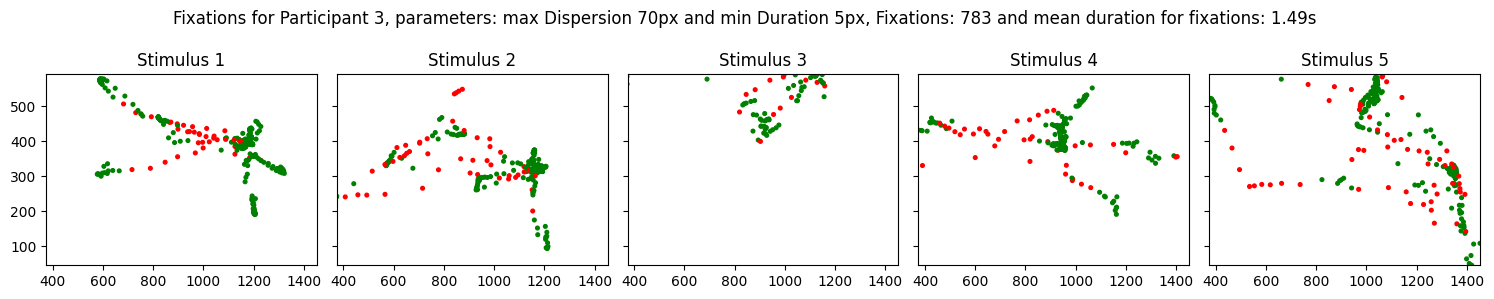

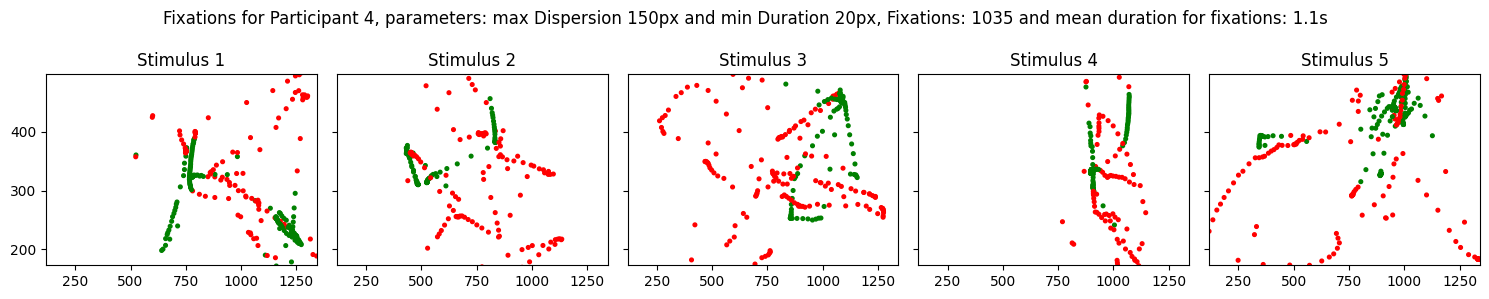

In [11]:
print(all_mean_durations_for_sets[0], all_fixations_for_sets)

def plot_fixations(segmented_data, params, index):
    n=2
    j=1
    for name, segments in segmented_data.items():
        # Defining plot
        fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
        fig.suptitle(f'Fixations for Participant {n}, parameters: max Dispersion {params[n-2][0]}px and min Duration {params[n-2][1]}px, Fixations: {all_fixations_for_sets[j]} and mean duration for fixations: {round(all_mean_durations_for_sets[j],2)}s')
        n+=1
        j+=1
        k=1
        for i, (segment_name, df) in enumerate(segments.items()):
            if not df.empty:

                fixation_color = ['green' if x == 'Fixation' else 'red' for x in df[f'Detected_Event_param{index}']]

                axes[i].scatter(df['x'], df['y'], color=fixation_color, s=7)
                axes[i].set_title(f'Stimulus {k}')
                k+=1
                axes[i].set_xlim(df['x'].min(), df['x'].max())
                axes[i].set_ylim(df['y'].min(), df['y'].max())

        plt.tight_layout()
        plt.show()

# Calling the function
plot_fixations(segmented_dfs, param_sets_1, 1)
plot_fixations(segmented_dfs, param_sets_2, 2)